### Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

Прочитаем файл data.csv и сохраним его в переменной df. Выведем три строчки датасета для просмотра.

In [2]:
df = pd.read_csv('/datasets/data.csv')

In [3]:
df.sample(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
16080,0,394233.127085,62,среднее,1,женат / замужем,0,F,пенсионер,0,159598.895363,на покупку подержанного автомобиля
19261,0,-347.576200,52,среднее,1,женат / замужем,0,F,компаньон,0,84466.947910,недвижимость
10873,0,NaN,53,среднее,1,Не женат / не замужем,4,F,сотрудник,0,NaN,жилье


Посмотрим общую информацию о данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Рассмотрим полученную информацию подробнее.

В представленных данных 6 количественных, 5 качественных и один булев параметров: всего 12 колонок с 21525 записями.

Подробно разберём, какие в df столбцы и какую информацию они содержат:

    children — количество детей в семье
    days_employed — общий трудовой стаж в днях
    dob_years — возраст клиента в годах
    education — уровень образования клиента
    education_id — идентификатор уровня образовани
    family_status — семейное положение
    family_status_id — идентификатор семейного положения
    gender — пол клиента
    income_type — тип занятости
    debt — имел ли задолженность по возврату кредитов
    total_income — ежемесячный доход
    purpose — цель получения кредита

### Вывод

Каждая строка таблицы - статистика о платежеспособности клиента банка. На основе этих данных необходимо разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Но есть ряд проблем, которые нужно решать перед исследованием: несколько столбцов нужно привести к целочисленному типу (трудовой стаж и ежемесячный доход) и по ним же обработать пропущенные значения, которые составляют порядка 10% от всего датасета. При этом наблюдаются отрицательные значения по стажу и количеству детей, что является вероятно всего опечаткой/неточностью в вводе данных.

Для проверки рабочих гипотез особенно ценны столбцы education и family_status. Данные из столбца purpose позволят узнать самые популярные цели для кредитования заемщиков. Правда перед этим нужно провести категоризацию данных.

### Этап 2. Предобработка данных

### Обработка пропусков

Проанализируем пропуски, заменим типы данных, а также проверим данные на наличие дубликатов.

Вернем все количественными параметрам абсолютное значение, чтобы избежать неточности в анализе данных.

In [5]:
col = df.select_dtypes(include=[np.number]).columns.values
df[col] = abs(df[col])

Как и указано ранее, в данных есть пропуски по двум параметрам. Чтобы наглядно отобразить, сколько же данных из нашего датасета пропущено, построим тепловую карту и подкрасим пропуски.

Text(0.5, 1, 'Анализ пропусков')

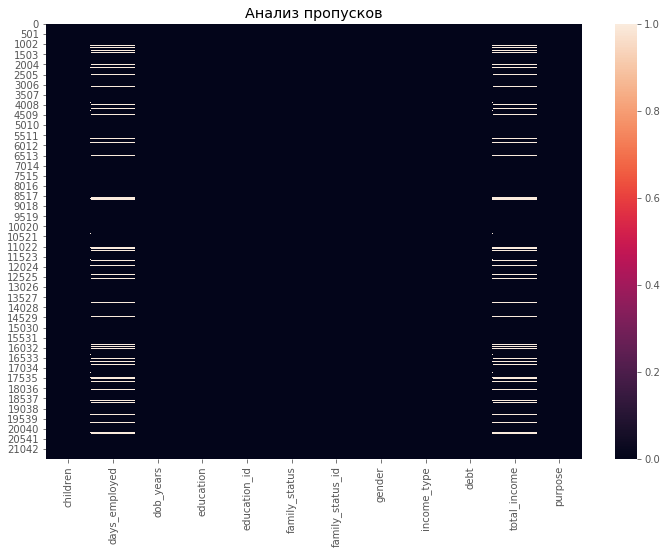

In [6]:
sns.heatmap(df.isnull()).set_title('Анализ пропусков')

На рисунке видно, что там, где есть пропуски по трудовому стажу, нет информации и о доходе клиента. То есть пропуски по двум метрикам идут синхронно.

Посмотрим, по каким категориям заемщиков больше всего пропусков в данных. Выведем отношение незаполненных сведений о доходе и трудовом стаже ко всем заемщикам в этой группе.

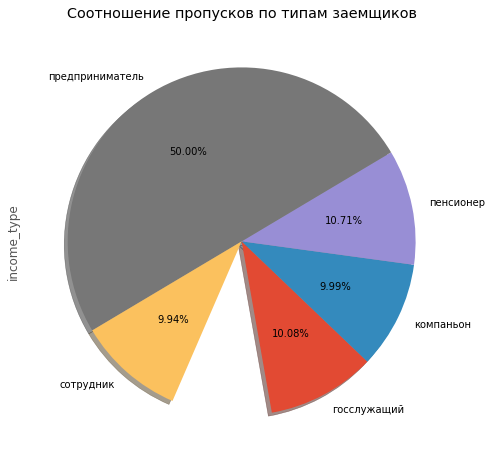

In [7]:
df1 = df.query('total_income != total_income')['income_type'].value_counts()/df['income_type'].value_counts()
df1[df1.notna()].plot.pie(shadow=True, 
                          startangle=280, 
                          autopct='%1.2f%%',
                          title = 'Соотношение пропусков по типам заемщиков')

Больше всего пропусков по информации о доходе у предпринимателей. Связано это с тем, что подтверждение дохода у данного типа заемщика связано с выбранной системой налогообложения. Почти на одном уровне по наличию пропусков сотрудник, госслужащий, компаньон и пенсионер. При этом, порядка 10% всех данных по категориям не имеет пропусков.

Заменим пропуски по трудовому стажу и ежемесячному догоду медианным значением методом transform.



In [8]:
df.loc[df['days_employed'].isnull(), 'days_employed'] = df.groupby('income_type')['days_employed'].transform('mean')
df.loc[df['total_income'].isnull(), 'total_income'] = df.groupby('income_type')['total_income'].transform('mean')

Кроме этого, несложно заметить, что у 76 (0,33% от всех) заемщиков указано 20 детей. Такое количество детей в семье - редкое явление, и ввиду немногочисленности таких заемщиков, имеет смысл от них избавиться (то есть считать выбросом в данных).

In [9]:
df = df.query('children != 20')

### Вывод

В таблице по 2174 строкам есть пропуски по общему трудовому стажу 'days_employed' и ежемесячному доходу 'total_income' - примерно 10,1% от всех данных (безработные, в декрете и студенты).

Если посмотреть тип занятости (переменная 'income_type') данных клиентов, то только 19% из них незанятые (пенсионеры - 413 человек), по остальным клиентам пропуски ошибочны.

Пропуски заполнены медианными значения по каждой группе клиентов.

Кроме того, есть пропуски значений в столбце по наличию дефолта.

### Замена типа данных

Заменим вещественный тип данных на целочисленный.

In [10]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')

### Обработка дубликатов

Для того, чтобы посмотреть, сколько в данных встречается дубликатов, приведем все записи по уровню образования в нижнему регистру. После этого можно смело удалять дубликаты.

In [11]:
print('Виды образования до метода lower: ', df['education'].unique().tolist())

df['education'] = df['education'].str.lower()

print()
print('Виды образования после метода lower: ', df['education'].unique().tolist())

Виды образования до метода lower:  ['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ', 'неоконченное высшее', 'начальное', 'Высшее', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ', 'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень']

Виды образования после метода lower:  ['высшее', 'среднее', 'неоконченное высшее', 'начальное', 'ученая степень']


In [12]:
df[df.duplicated()]['total_income'].count()

71

In [13]:
df=df.drop_duplicates().reset_index(drop=True)

### Вывод

После замены всех пропусков по трудовому стажу и ежемесячному доходу клиентов, заменен вещественный тип данных на целочисленный. Для изменения типа данных использовала метод astype.

В данных несколько видов записи уровня образования. Поэтому необходимо привести все записи к нижнему регистру. Дубли в записях по уровню образования могут быть из-за ручного заполнения исходной таблицы. Дубликаты в количестве 71 удалены методом drop_deplicates().

### Лемматизация

Если внимательно посмотреть на информацию о целях кредитования, можно заметить большую вариативность написания целей.

Чтобы увеличить точность анализа данных, проведем лемматизацию по столбцу 'purpose'. Для этого воспользуемся библиотеками pymystem3 и Counter.

Принцип лемматизации состоит в поиске самых популярных слов (lemmas) и приведению каждой записи таблицы к унифицированной цели кредитования (функция lemma_purpose).

In [14]:
from pymystem3 import Mystem
from collections import Counter

m = Mystem()

# находим список самых популярных слов
lemmas = []
for index in df['purpose']:
    lemmas += m.lemmatize(index)

# функция для леммитизации:
def lemma_purpose(row):
    lemma_purposes = m.lemmatize(row['purpose'])
    if 'недвижимость' in lemma_purposes:
        return 'недвижимость'
    if 'жилье' in lemma_purposes:
        return 'жилье'
    if 'автомобиль' in lemma_purposes:
        return 'автомобиль'
    if 'образование' in lemma_purposes:
        return 'образование'
    if 'свадьба' in lemma_purposes:
        return 'свадьба'
    return 'другое'
 
df['purpose_category'] = df.apply(lemma_purpose, axis=1)

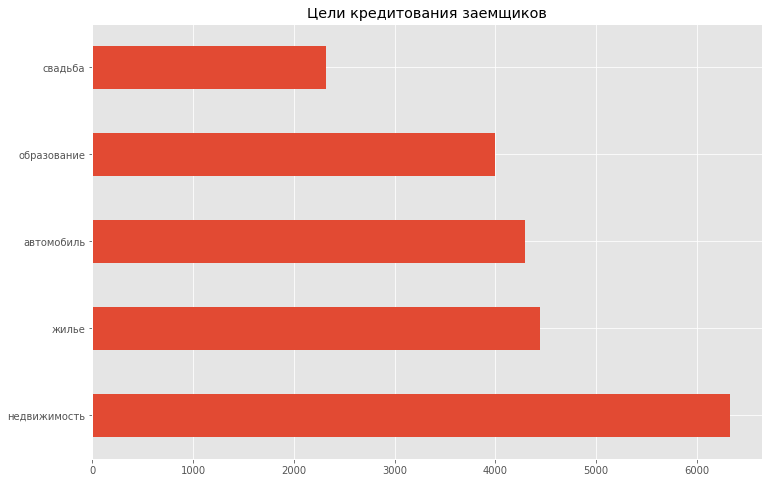

In [15]:
df['purpose_category'].value_counts().plot.barh(title='Цели кредитования заемщиков')

### Вывод

В результате проведения лемматизации, имеем новый столбец 'purpose_category' с основными целями кредитования. Самая популярная цель - покупка недвижимости или жилья. А вот на свадьбу кредитные срества берут меньше всего - и правильно делают! :)

### Категоризация данных

Чтобы ответить на вопрос о влиянии уровня образования и семейного положения клиента на его платежеспособность, необходимо проверсти категоризацию данных. 

Для этого выделим словари по уровню образования и семейного статуса.

С помощью функции income_category, по квантелям запишем уровень дохода (низкий, высокий, средний).

In [16]:
education_dict = df[['education_id', 'education']].drop_duplicates().reset_index(drop=True)
family_stat_dict = df[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)

df['total_income'].quantile([0.25, 0.50, 0.75])
 
def income_category(row):
    
    ''' ------------------------------------------------------
        Функция для категоризации уровня доходов по квантилям:
        - меньше 25% - низкий доход,
        - от 25% до 75% - средний доход,
        - выше 75% - высокий доход 
        ------------------------------------------------------ '''
    
    if row['total_income'] <= df['total_income'].quantile(0.25):
        return 'низкий'
    elif row['total_income'] >= df['total_income'].quantile(0.75):
        return 'высокий'
    else:
        return 'средний'

df['income_category'] = df.apply(income_category, axis=1)

Text(0.5, 0.98, 'Распределение дохода заемщиков')

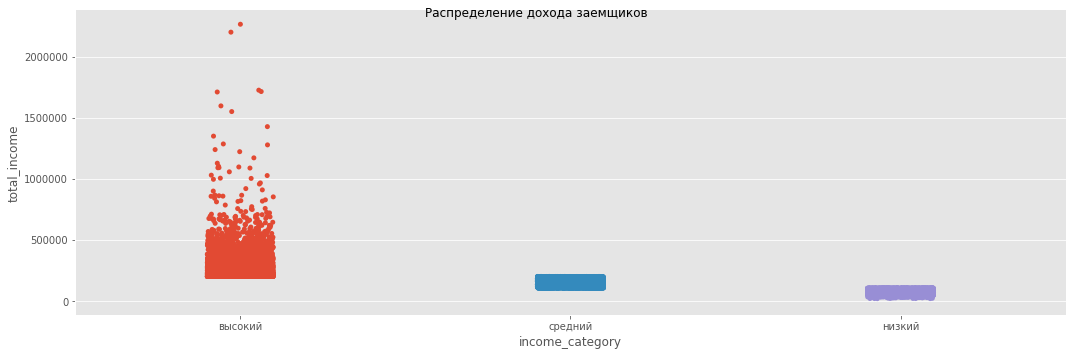

In [17]:
g = sns.catplot(x = "income_category", y = "total_income", data = df, height=5, aspect=3)
g.fig.suptitle("Распределение дохода заемщиков")

### Вывод

На данном этапе есть все данные для проведения анализа и ответов на ключевые вопросы.

### Этап 3. Ответы на вопросы

Чтобы найти зависимость между характестистиками заемщика (кол-во детей в семье, семейное положение заемщика и уровень его дохода) и возвратом кредита в срок (стоблец debt), необходимо сгруппировать данные по дефолту. На основании этой группировки рассчитаем долю просрочки по каждому параметру. Для автоматизации расчета напишем функцию rate_categoty. Данные представим на графиках: первый показывает распределение каждого значения в категории, второй - доля просроченной задолженности по этой категории.

In [18]:
def rate_categoty(column, title):
    
    '''-------------------------------------------------
       Функция для расчёта доли просрочки по кредиту
       в зависимости от различных параметров. 
       Вывод распределения каждого значения в категории,
       а также доли просрочки по категории.    
      -------------------------------------------------- '''
    
    table = df.pivot_table(index=column, values = 'debt', aggfunc ={'sum', 'count'}).reset_index()
    table['rate'] = round(table['count'] * 100 / table['count'].sum(), 2)
    table['rate_debt'] = round(table['sum'] * 100 /  table['count'].sum(), 2)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.pie(table['rate'],
            labels=table[column],
            startangle=280,
            autopct='%1.0f%%')
    ax2.bar(table[column], 
            table['rate_debt'])
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    
    return table

Посмотрим, есть ли зависимость между наличием детей и возвратом кредита в срок?

,children,count,sum,rate,rate_debt
0,0.0,14091,1063.0,65.91,4.97
1,1.0,4855,445.0,22.71,2.08
2,2.0,2052,194.0,9.60,0.91
3,3.0,330,27.0,1.54,0.13
4,4.0,41,4.0,0.19,0.02
5,5.0,9,0.0,0.04,0.00


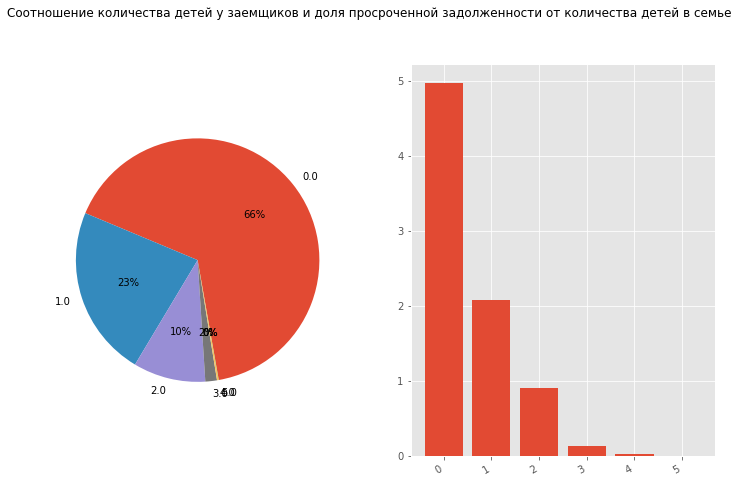

In [19]:
rate_categoty('children', 
              'Соотношение количества детей у заемщиков и доля просроченной задолженности от количества детей в семье')

### Вывод

Самые добропоряжочные заемщики - те, у кого пятеро детей (у них нет просроченной задолженности по кредиту). В то же время таких клиентов всего 0.04% от общего числа. 

Большинство заемщиков банка не имеют детей, - их доля просрочки по кредиту больше всего.

А как влияет семейное положение клиента на его способность вернуть деньги в срок?

,family_status,count,sum,rate,rate_debt
0,Не женат / не замужем,2801,273.0,13.10,1.28
1,в разводе,1193,84.0,5.58,0.39
2,вдовец / вдова,955,63.0,4.47,0.29
3,гражданский брак,4139,385.0,19.36,1.80
4,женат / замужем,12290,928.0,57.49,4.34


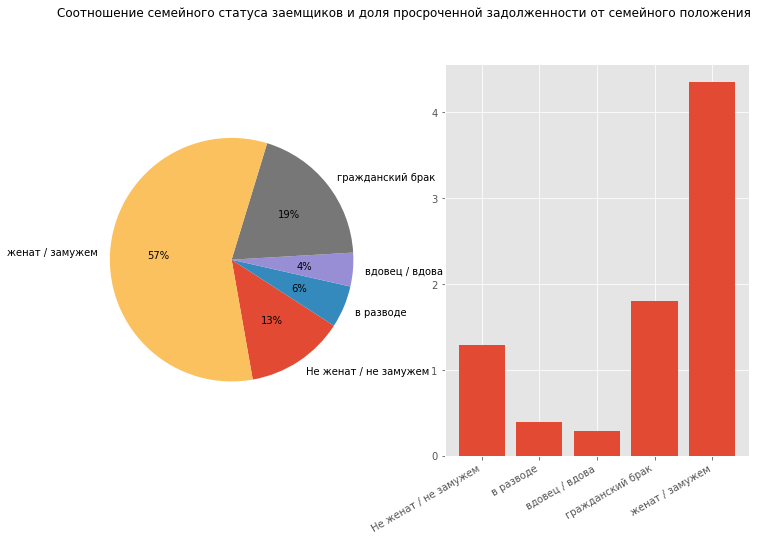

In [20]:
rate_categoty('family_status', 
              'Соотношение семейного статуса заемщиков и доля просроченной задолженности от семейного положения')

### Вывод

Меньше всего просрочки имеют вдовцы, при этом они составляют самую малу долю от всего числа заемщиков (4.47%).
Больше всего допускают просрочку не женатые заемщики.

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

,income_category,count,sum,rate,rate_debt
0,высокий,5388,373.0,25.20,1.74
1,низкий,5345,427.0,25.00,2.00
2,средний,10645,933.0,49.79,4.36


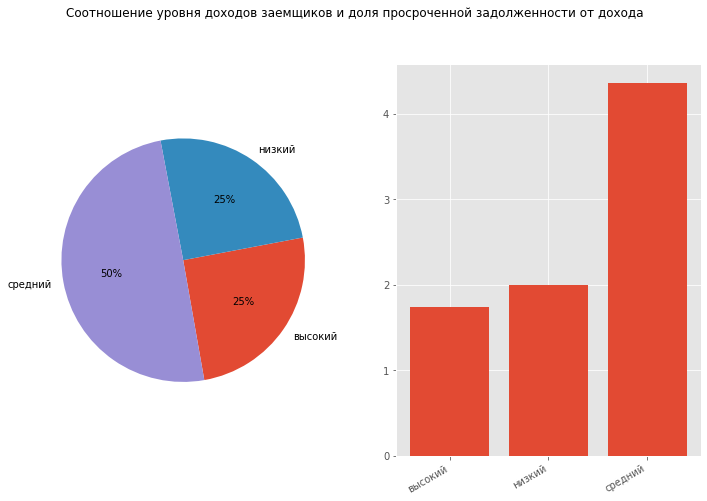

In [21]:
rate_categoty('income_category', 
              'Соотношение уровня доходов заемщиков и доля просроченной задолженности от дохода')

### Вывод

Самая большая доля просрочки у клиентов со средним доходом, самая маленькая - с высоким доходом.

Как разные цели кредита влияют на его возврат в срок?

,purpose_category,count,sum,rate,rate_debt
0,автомобиль,4290,401.0,20.07,1.88
1,жилье,4445,308.0,20.79,1.44
2,недвижимость,6330,472.0,29.61,2.21
3,образование,3998,369.0,18.70,1.73
4,свадьба,2315,183.0,10.83,0.86


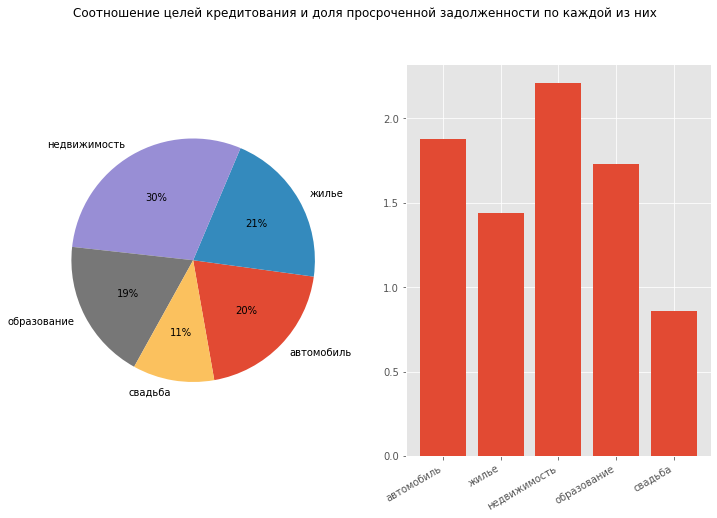

In [22]:
rate_categoty('purpose_category', 
              'Соотношение целей кредитования и доля просроченной задолженности по каждой из них')

### Вывод

Больше всего просрочки допускают клиенты банка, взявшие автокредит. Немного позади них - кредит на образование.
Самые добросовестные и ответственные заемщики - взявшие кредит на жилье.

### Этап 4. Общий вывод

Анализ кредитоспособности заемщиков банка проведен: определили основные цели кредита, типы клиентов банка, а также зависимость дефолта от разных показателей. 

Самая высокая доля просрочки у не женатых клиентов со средним уровнем дохода, взявших автокредит или кредит на образование. При этом прослеживается прямая зависимость просрочки от кол-ва детей в семье: чем больше детей у клиентов банка, тем выше просрочка по кредитам.

Самые ответственные кредитозаемщики банка - клиенты без детей и\или в разводе. Что логично - у людей нет других дополнительных трат на семью. Обычно такие клиенты имеют высокий уровень дохода по сравнению с другими клиентами банка и цель их кредитования - покупка жилья.